In [1]:
#pip install qiskit cirq pandas Pillow torchvision torch matplotlib "scikit-learn>=1.3.0,<1.4.0" "tensorcircuit>=0.11.0,<0.12.0" "jax==0.4.13" "flax>=0.7.1,<0.8.0" "optax>=0.1.7,<0.2.0" "ipykernel>=6.25.0,<6.26.0" "jupyterlab>=4.0.11,<4.1.0" "matplotlib>=3.7.2,<3.8.0" "tensorflow-datasets>=4.9.2,<4.10.0" "tensorflow>=2.14.0,<2.15.0" "ipywidgets>=8.1.0,<8.2.0" "tqdm>=4.65.0,<4.66.0" "numpy>=1.25.2,<1.26.0" "gdown>=4.7.1,<4.8.0" "qiskit>=0.44.0,<0.45.0" "pylatexenc>=2.10,<2.11" "tensorflow-text>=2.14.0,<2.15.0" "ray[tune]>=2.6.3,<2.7.0" jaxlib==0.4.13

In [1]:
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [2]:
# Folders to labels
folders = {
    'Mild Dementia': 1,
    'Moderate Dementia': 1,
    'Very mild Dementia': 1,
    'Non Dementia': 0
}

data = []
base_path = 'Oasis_Data'

# Loop through each folder in your directory mapping
for folder, label in folders.items():
    folder_path = os.path.join(base_path, folder)
    for file in os.listdir(folder_path):
        if file.endswith('.jpg') or file.endswith('.png'):
            data.append({
                'file_path': os.path.join(folder_path, file),
                'label': label
            })

df = pd.DataFrame(data)
print(df.head(10))
print(df.shape)
print(df['label'].value_counts())

                                           file_path  label
0  Oasis_Data/Mild Dementia/OAS1_0137_MR1_mpr-3_1...      1
1  Oasis_Data/Mild Dementia/OAS1_0291_MR1_mpr-3_1...      1
2  Oasis_Data/Mild Dementia/OAS1_0278_MR1_mpr-2_1...      1
3  Oasis_Data/Mild Dementia/OAS1_0382_MR1_mpr-4_1...      1
4  Oasis_Data/Mild Dementia/OAS1_0316_MR1_mpr-1_1...      1
5  Oasis_Data/Mild Dementia/OAS1_0316_MR1_mpr-1_1...      1
6  Oasis_Data/Mild Dementia/OAS1_0278_MR1_mpr-2_1...      1
7  Oasis_Data/Mild Dementia/OAS1_0382_MR1_mpr-4_1...      1
8  Oasis_Data/Mild Dementia/OAS1_0052_MR1_mpr-4_1...      1
9  Oasis_Data/Mild Dementia/OAS1_0291_MR1_mpr-3_1...      1
(86437, 2)
label
0    67222
1    19215
Name: count, dtype: int64


In [3]:
class BalancedMRIDataset(Dataset):
    def __init__(self, dataframe, transform=None, mode='train'):
        self.dataframe = dataframe
        self.transform = transform
        self.mode = mode
        if mode == 'train':
            self.demented_df = dataframe[dataframe['label'] == 1]
            self.nondemented_df = dataframe[dataframe['label'] == 0]
            self.oversample_size = len(self.nondemented_df) - len(self.demented_df)

    def __len__(self):
        if self.mode == 'train':
            return 2 * len(self.nondemented_df)  # Ensuring balanced classes in training
        else:
            return len(self.dataframe)

    def __getitem__(self, idx):
        if self.mode == 'train' and idx >= len(self.nondemented_df):
            # Handle augmented demented images
            idx = idx - len(self.nondemented_df)
            row = self.demented_df.iloc[idx % len(self.demented_df)]
            label = 1
        else:
            row = self.dataframe.iloc[idx]
            label = row['label']
        
        img_path = row['file_path']
        image = Image.open(img_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
        
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [4]:
# Splitting the dataset
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['label'], random_state=42)  # 0.25 x 0.8 = 0.2

In [54]:
# Defining transformations
transformations = transforms.Compose([
    transforms.Resize(60),
    transforms.CenterCrop(96),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

augment_transformations = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.Resize(60),
    transforms.CenterCrop(96),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [55]:
# Create datasets
train_dataset = BalancedMRIDataset(train_df, transform=augment_transformations, mode='train')
val_dataset = BalancedMRIDataset(val_df, transform=transformations, mode='validate')
test_dataset = BalancedMRIDataset(test_df, transform=transformations, mode='test')

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [56]:
def get_dataset_info(loader):
    label_count = {0: 0, 1: 0}
    for images, labels in loader:
        print("Batch image shape:", images.shape)
        for label in labels:
            label_count[int(label)] += 1
        break  # Remove this line if you want to go through the whole dataset
    print("Label counts:", label_count)

# Call the function with your DataLoader
get_dataset_info(train_loader)
get_dataset_info(val_loader)
get_dataset_info(test_loader)


Batch image shape: torch.Size([16, 1, 96, 96])
Label counts: {0: 8, 1: 8}
Batch image shape: torch.Size([16, 1, 96, 96])
Label counts: {0: 12, 1: 4}
Batch image shape: torch.Size([16, 1, 96, 96])
Label counts: {0: 13, 1: 3}


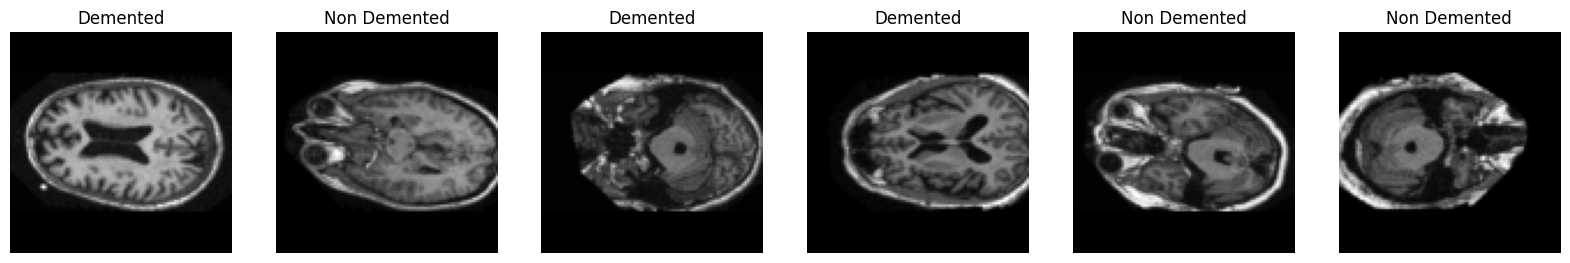

In [62]:
def show_images_with_labels(loader, num_images=8):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    found_non_demented = 0
    found_demented = 0
    
    for images, labels in loader:
        for i, (image, label) in enumerate(zip(images, labels)):
            if (label == 0 and found_non_demented < num_images // 2) or (label == 1 and found_demented < num_images // 2):
                ax = axes[found_non_demented + found_demented]
                img = image.numpy()
                img = np.transpose(img, (1, 2, 0))
                ax.imshow(img * 0.5 + 0.5, cmap='gray')  # Unnormalize
                label_text = 'Non Demented' if label == 0 else 'Demented'
                ax.set_title(label_text)
                ax.axis('off')
                if label == 0:
                    found_non_demented += 1
                else:
                    found_demented += 1
            if found_non_demented >= num_images // 2 and found_demented >= num_images // 2:
                break
        if found_non_demented >= num_images // 2 and found_demented >= num_images // 2:
            break

show_images_with_labels(train_loader, 6)


In [63]:
# Assuming the BalancedMRIDataset class is correctly implemented
print(f"Number of nondemented images (Label 0): {len(train_dataset.nondemented_df)}")
# For the demented images, since they are oversampled to match the nondemented count in training mode:
if train_dataset.mode == 'train':
    print(f"Number of demented images (Label 1) after oversampling: {len(train_dataset.nondemented_df)}")
else:
    print(f"Number of demented images (Label 1) without oversampling: {len(train_dataset.demented_df)}")


Number of nondemented images (Label 0): 40332
Number of demented images (Label 1) after oversampling: 40332


break

In [6]:
from sklearn.model_selection import train_test_split

train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df['label'], random_state=42)  

# Optionally sample the training and validation set for hyperparameter tuning
#train_df = train_df.sample(frac=0.1, random_state=42)  # Adjust frac as needed for tuning
#val_df = val_df.sample(frac=0.5, random_state=42)  # Optionally adjust frac as needed for tuning

train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()

# Note: The test set should not be sampled or altered from its initial split
# test_df remains as is for final model evaluation to ensure accuracy of performance metrics

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Testing set size: {len(test_df)}") 


Training set size: 55319
Validation set size: 13830
Testing set size: 17288


In [7]:
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch

class MRIDataset(Dataset):
    def __init__(self, dataframe, transform=None, augment_transform=None, oversample_demented=False, additional_demented=30000):
        self.dataframe = dataframe
        self.transform = transform
        self.augment_transform = augment_transform
        self.oversample_demented = oversample_demented
        self.additional_demented = additional_demented
        if oversample_demented:
            self.demented_indices = self.dataframe[self.dataframe['label'] == 1].index.tolist()
            self.num_original_demented = len(self.demented_indices)

    def __len__(self):
        if self.oversample_demented:
            return len(self.dataframe) + self.additional_demented
        return len(self.dataframe)

    def __getitem__(self, idx):
        if idx >= len(self.dataframe):
            # Handle augmented demented images
            new_idx = idx - len(self.dataframe)
            img_idx = self.demented_indices[new_idx % self.num_original_demented]
            label = 1
        else:
            img_idx = idx
            label = self.dataframe.iloc[img_idx]['label']
        
        img_path = self.dataframe.iloc[img_idx]['file_path']
        image = Image.open(img_path).convert('L')
        
        if idx >= len(self.dataframe) and self.augment_transform is not None:
            # Apply augmentation for additional demented images
            image = self.augment_transform(image)
        elif self.transform:
            image = self.transform(image)
        
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [8]:
transformations = transforms.Compose([
    transforms.Resize(75),
    transforms.CenterCrop(75),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

augment_transformations = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),  # Make sure this is here
])


In [9]:
# Create datasets with dynamic augmentation for the demented class
train_dataset = MRIDataset(train_df, transform=transformations, augment_transform=augment_transformations, oversample_demented=True, additional_demented=30000)
val_dataset = MRIDataset(val_df, transform=transformations)
test_dataset = MRIDataset(test_df, transform=transformations)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [10]:
def get_dataset_info(loader):
    label_count = {0: 0, 1: 0}
    for images, labels in loader:
        print("Batch image shape:", images.shape)
        for label in labels:
            label_count[int(label)] += 1
        break  # Remove this line if you want to go through the whole dataset

    print("Label counts:", label_count)

# Call the function with your training DataLoader
get_dataset_info(train_loader)
get_dataset_info(val_loader)
get_dataset_info(test_loader)



RuntimeError: stack expects each tensor to be equal size, but got [1, 75, 75] at entry 0 and [1, 248, 496] at entry 1

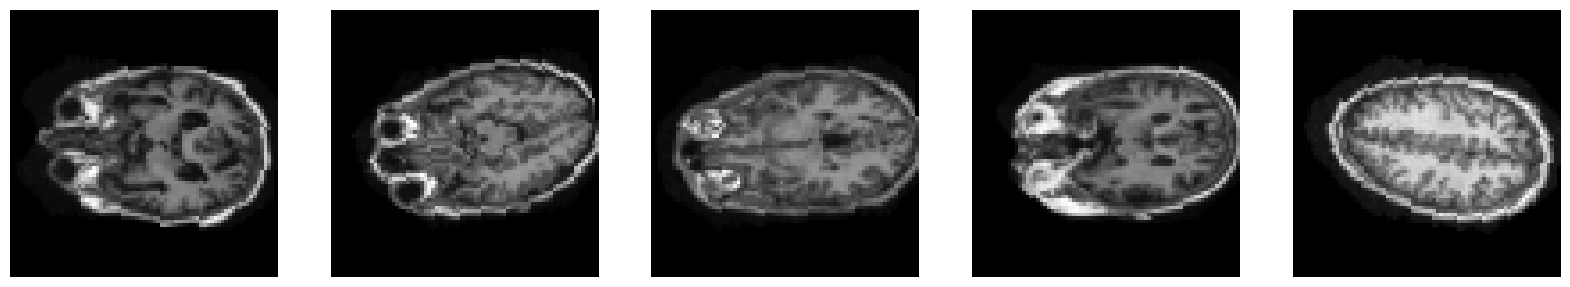

In [ ]:
def show_images_with_labels(loader, num_images=8):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    found_non_demented = 0
    found_demented = 0
    
    for images, labels in loader:
        for i, (image, label) in enumerate(zip(images, labels)):
            if (label == 0 and found_non_demented < num_images // 2) or (label == 1 and found_demented < num_images // 2):
                ax = axes[found_non_demented + found_demented]
                img = image.numpy()
                img = np.transpose(img, (1, 2, 0))
                ax.imshow(img * 0.5 + 0.5, cmap='gray')  # Unnormalize
                label_text = 'Non Demented' if label == 0 else 'Demented'
                ax.set_title(label_text)
                ax.axis('off')
                if label == 0:
                    found_non_demented += 1
                else:
                    found_demented += 1
            if found_non_demented >= num_images // 2 and found_demented >= num_images // 2:
                break
        if found_non_demented >= num_images // 2 and found_demented >= num_images // 2:
            break

show_images_with_labels(train_loader, 8)

In [ ]:
import jax
import jaxlib

from quantum_transformers.utils import plot_image
from quantum_transformers.datasets import get_mnist_dataloaders
from quantum_transformers.training import train_and_evaluate
from quantum_transformers.transformers import VisionTransformer
from quantum_transformers.quantum_layer import get_circuit

model = VisionTransformer(
    num_classes=2,  # Keep binary classification
    patch_size=5,
    hidden_size=10,  # Reduce model complexity
    num_heads=5,  # Reduce number of heads
    num_transformer_blocks=8,  # Reduce the depth
    mlp_hidden_size=6,  # Reduce MLP block size
    quantum_attn_circuit=get_circuit(),
    quantum_mlp_circuit=get_circuit(),
    pos_embedding='learn'  # Positional embedding
)

Please first ``pip install -U qiskit`` to enable related functionality in translation module


In [ ]:
for d in jax.devices():
    print(d, d.device_kind)

TFRT_CPU_0 cpu


In [ ]:
num_classes = 2  # binary classification
num_epochs = 75  # number of epochs

# Call the train_and_evaluate function with the adjusted parameters
test_loss, test_auc, test_fpr, test_tpr, all_logits, all_labels = train_and_evaluate(
    model=model, 
    train_dataloader=train_loader, 
    val_dataloader=val_loader, 
    test_dataloader=test_loader, 
    num_classes=num_classes,
    num_epochs=num_epochs,
)


Number of parameters = 21490
Starting training for 50 epochs...


Epoch   1/50:   0%|          | 0/1729 [00:00<?, ?batch/s]2024-02-20 23:34:39.151989: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_train_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-02-20 23:50:52.011004: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 18m12.864712s

********************************
[Compiling module jit_train_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch   1/50: 100%|█████████▉| 1728/1729 [25:06<00:00,  4.79batch/s]   2024-02-21 00:16:17.332654: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 18m8.301769s

********************************
[Compiling module jit_train_step] Very slow compile? If you want to file a bug, ru

Epoch 1 completed. Validation Loss: 0.4485, Validation AUC: 77.40%


Epoch   2/50: 100%|██████████| 1729/1729 [07:09<00:00,  4.03batch/s, Loss = 0.4485, AUC = 79.41%]


Epoch 2 completed. Validation Loss: 0.4485, Validation AUC: 79.41%


Epoch   3/50: 100%|██████████| 1729/1729 [07:01<00:00,  4.10batch/s, Loss = 0.4264, AUC = 80.03%]


Epoch 3 completed. Validation Loss: 0.4264, Validation AUC: 80.03%


Epoch   4/50: 100%|██████████| 1729/1729 [07:14<00:00,  3.98batch/s, Loss = 0.4325, AUC = 80.20%]


Epoch 4 completed. Validation Loss: 0.4325, Validation AUC: 80.20%


Epoch   5/50: 100%|██████████| 1729/1729 [07:12<00:00,  3.99batch/s, Loss = 0.4202, AUC = 80.75%]


Epoch 5 completed. Validation Loss: 0.4202, Validation AUC: 80.75%


Epoch   6/50: 100%|██████████| 1729/1729 [06:12<00:00,  4.64batch/s, Loss = 0.4184, AUC = 80.63%]


Epoch 6 completed. Validation Loss: 0.4184, Validation AUC: 80.63%


Epoch   7/50: 100%|██████████| 1729/1729 [05:57<00:00,  4.84batch/s, Loss = 0.4126, AUC = 81.03%]


Epoch 7 completed. Validation Loss: 0.4126, Validation AUC: 81.03%


Epoch   8/50: 100%|██████████| 1729/1729 [05:55<00:00,  4.86batch/s, Loss = 0.4145, AUC = 81.33%]


Epoch 8 completed. Validation Loss: 0.4145, Validation AUC: 81.33%


Epoch   9/50: 100%|██████████| 1729/1729 [05:54<00:00,  4.88batch/s, Loss = 0.4239, AUC = 81.42%]


Epoch 9 completed. Validation Loss: 0.4239, Validation AUC: 81.42%


Epoch  10/50: 100%|██████████| 1729/1729 [03:51<00:00,  7.47batch/s, Loss = 0.4080, AUC = 81.76%]


Epoch 10 completed. Validation Loss: 0.4080, Validation AUC: 81.76%


Epoch  11/50: 100%|██████████| 1729/1729 [03:45<00:00,  7.67batch/s, Loss = 0.4070, AUC = 82.18%]


Epoch 11 completed. Validation Loss: 0.4070, Validation AUC: 82.18%


Epoch  12/50: 100%|██████████| 1729/1729 [03:45<00:00,  7.66batch/s, Loss = 0.4059, AUC = 82.11%]


Epoch 12 completed. Validation Loss: 0.4059, Validation AUC: 82.11%


Epoch  13/50: 100%|██████████| 1729/1729 [03:45<00:00,  7.67batch/s, Loss = 0.3975, AUC = 83.52%]


Epoch 13 completed. Validation Loss: 0.3975, Validation AUC: 83.52%


Epoch  14/50: 100%|██████████| 1729/1729 [03:46<00:00,  7.63batch/s, Loss = 0.3915, AUC = 83.68%]


Epoch 14 completed. Validation Loss: 0.3915, Validation AUC: 83.68%


Epoch  15/50: 100%|██████████| 1729/1729 [03:44<00:00,  7.71batch/s, Loss = 0.3864, AUC = 84.53%]


Epoch 15 completed. Validation Loss: 0.3864, Validation AUC: 84.53%


Epoch  16/50: 100%|██████████| 1729/1729 [03:43<00:00,  7.72batch/s, Loss = 0.3804, AUC = 85.43%]


Epoch 16 completed. Validation Loss: 0.3804, Validation AUC: 85.43%


Epoch  17/50: 100%|██████████| 1729/1729 [03:44<00:00,  7.72batch/s, Loss = 0.3779, AUC = 85.59%]


Epoch 17 completed. Validation Loss: 0.3779, Validation AUC: 85.59%


Epoch  18/50: 100%|██████████| 1729/1729 [03:43<00:00,  7.73batch/s, Loss = 0.3726, AUC = 85.75%]


Epoch 18 completed. Validation Loss: 0.3726, Validation AUC: 85.75%


Epoch  19/50: 100%|██████████| 1729/1729 [03:44<00:00,  7.72batch/s, Loss = 0.3665, AUC = 86.49%]


Epoch 19 completed. Validation Loss: 0.3665, Validation AUC: 86.49%


Epoch  20/50: 100%|██████████| 1729/1729 [03:43<00:00,  7.73batch/s, Loss = 0.3647, AUC = 86.54%]


Epoch 20 completed. Validation Loss: 0.3647, Validation AUC: 86.54%


Epoch  21/50: 100%|██████████| 1729/1729 [04:09<00:00,  6.92batch/s, Loss = 0.3602, AUC = 86.97%]


Epoch 21 completed. Validation Loss: 0.3602, Validation AUC: 86.97%


Epoch  22/50: 100%|██████████| 1729/1729 [05:34<00:00,  5.17batch/s, Loss = 0.3582, AUC = 87.28%]


Epoch 22 completed. Validation Loss: 0.3582, Validation AUC: 87.28%


Epoch  23/50: 100%|██████████| 1729/1729 [05:52<00:00,  4.91batch/s, Loss = 0.3559, AUC = 87.38%]


Epoch 23 completed. Validation Loss: 0.3559, Validation AUC: 87.38%


Epoch  24/50: 100%|██████████| 1729/1729 [05:51<00:00,  4.92batch/s, Loss = 0.3532, AUC = 87.53%]


Epoch 24 completed. Validation Loss: 0.3532, Validation AUC: 87.53%


Epoch  25/50: 100%|██████████| 1729/1729 [05:55<00:00,  4.87batch/s, Loss = 0.3541, AUC = 87.57%]


Epoch 25 completed. Validation Loss: 0.3541, Validation AUC: 87.57%


Epoch  26/50: 100%|██████████| 1729/1729 [05:54<00:00,  4.88batch/s, Loss = 0.3508, AUC = 87.73%]


Epoch 26 completed. Validation Loss: 0.3508, Validation AUC: 87.73%


Epoch  27/50: 100%|██████████| 1729/1729 [05:47<00:00,  4.97batch/s, Loss = 0.3511, AUC = 87.74%]


Epoch 27 completed. Validation Loss: 0.3511, Validation AUC: 87.74%


Epoch  28/50: 100%|██████████| 1729/1729 [05:52<00:00,  4.90batch/s, Loss = 0.3509, AUC = 87.74%]


Epoch 28 completed. Validation Loss: 0.3509, Validation AUC: 87.74%


Epoch  29/50: 100%|██████████| 1729/1729 [05:57<00:00,  4.83batch/s, Loss = 0.3506, AUC = 87.76%]


Epoch 29 completed. Validation Loss: 0.3506, Validation AUC: 87.76%


Epoch  30/50: 100%|██████████| 1729/1729 [06:01<00:00,  4.78batch/s, Loss = 0.3506, AUC = 87.76%]


Epoch 30 completed. Validation Loss: 0.3506, Validation AUC: 87.76%


Epoch  31/50: 100%|██████████| 1729/1729 [06:00<00:00,  4.80batch/s, Loss = 0.3506, AUC = 87.76%]


Epoch 31 completed. Validation Loss: 0.3506, Validation AUC: 87.76%


Epoch  32/50: 100%|██████████| 1729/1729 [05:59<00:00,  4.81batch/s, Loss = 0.3506, AUC = 87.76%]


Epoch 32 completed. Validation Loss: 0.3506, Validation AUC: 87.76%


Epoch  33/50: 100%|██████████| 1729/1729 [05:56<00:00,  4.86batch/s, Loss = 0.3506, AUC = 87.76%]


Epoch 33 completed. Validation Loss: 0.3506, Validation AUC: 87.76%


Epoch  34/50: 100%|██████████| 1729/1729 [05:58<00:00,  4.82batch/s, Loss = 0.3506, AUC = 87.76%]


Epoch 34 completed. Validation Loss: 0.3506, Validation AUC: 87.76%


Epoch  35/50: 100%|██████████| 1729/1729 [05:59<00:00,  4.81batch/s, Loss = 0.3506, AUC = 87.76%]


Epoch 35 completed. Validation Loss: 0.3506, Validation AUC: 87.76%


Epoch  36/50: 100%|██████████| 1729/1729 [05:57<00:00,  4.84batch/s, Loss = 0.3506, AUC = 87.76%]


Epoch 36 completed. Validation Loss: 0.3506, Validation AUC: 87.76%


Epoch  37/50: 100%|██████████| 1729/1729 [05:57<00:00,  4.83batch/s, Loss = 0.3506, AUC = 87.76%]


Epoch 37 completed. Validation Loss: 0.3506, Validation AUC: 87.76%


Epoch  38/50: 100%|██████████| 1729/1729 [05:58<00:00,  4.82batch/s, Loss = 0.3506, AUC = 87.76%]


Epoch 38 completed. Validation Loss: 0.3506, Validation AUC: 87.76%


Epoch  39/50: 100%|██████████| 1729/1729 [06:00<00:00,  4.80batch/s, Loss = 0.3506, AUC = 87.76%]


Epoch 39 completed. Validation Loss: 0.3506, Validation AUC: 87.76%


Epoch  40/50: 100%|██████████| 1729/1729 [06:01<00:00,  4.78batch/s, Loss = 0.3506, AUC = 87.76%]


Epoch 40 completed. Validation Loss: 0.3506, Validation AUC: 87.76%


Epoch  41/50: 100%|██████████| 1729/1729 [06:00<00:00,  4.80batch/s, Loss = 0.3506, AUC = 87.76%]


Epoch 41 completed. Validation Loss: 0.3506, Validation AUC: 87.76%


Epoch  42/50: 100%|██████████| 1729/1729 [05:55<00:00,  4.86batch/s, Loss = 0.3506, AUC = 87.76%]


Epoch 42 completed. Validation Loss: 0.3506, Validation AUC: 87.76%


Epoch  43/50: 100%|██████████| 1729/1729 [05:58<00:00,  4.82batch/s, Loss = 0.3506, AUC = 87.76%]


Epoch 43 completed. Validation Loss: 0.3506, Validation AUC: 87.76%


Epoch  44/50: 100%|██████████| 1729/1729 [06:00<00:00,  4.80batch/s, Loss = 0.3506, AUC = 87.76%]


Epoch 44 completed. Validation Loss: 0.3506, Validation AUC: 87.76%


Epoch  45/50: 100%|██████████| 1729/1729 [05:53<00:00,  4.89batch/s, Loss = 0.3506, AUC = 87.76%]


Epoch 45 completed. Validation Loss: 0.3506, Validation AUC: 87.76%


Epoch  46/50: 100%|██████████| 1729/1729 [05:45<00:00,  5.01batch/s, Loss = 0.3506, AUC = 87.76%]


Epoch 46 completed. Validation Loss: 0.3506, Validation AUC: 87.76%


Epoch  47/50: 100%|██████████| 1729/1729 [05:38<00:00,  5.11batch/s, Loss = 0.3506, AUC = 87.76%]


Epoch 47 completed. Validation Loss: 0.3506, Validation AUC: 87.76%


Epoch  48/50: 100%|██████████| 1729/1729 [05:37<00:00,  5.12batch/s, Loss = 0.3506, AUC = 87.76%]


Epoch 48 completed. Validation Loss: 0.3506, Validation AUC: 87.76%


Epoch  49/50: 100%|██████████| 1729/1729 [05:37<00:00,  5.13batch/s, Loss = 0.3506, AUC = 87.76%]


Epoch 49 completed. Validation Loss: 0.3506, Validation AUC: 87.76%


Epoch  50/50: 100%|██████████| 1729/1729 [05:33<00:00,  5.18batch/s, Loss = 0.3506, AUC = 87.76%]


Epoch 50 completed. Validation Loss: 0.3506, Validation AUC: 87.76%
Total training time = 19450.81s, best validation AUC = 87.76% at epoch 29
Total training time: 19461.44 seconds
Training Losses: []
Training AUCs: []
Validation Losses: [Array(0.44851783, dtype=float32), Array(0.448482, dtype=float32), Array(0.42638582, dtype=float32), Array(0.43247125, dtype=float32), Array(0.42015347, dtype=float32), Array(0.4183896, dtype=float32), Array(0.41259786, dtype=float32), Array(0.4144955, dtype=float32), Array(0.42392483, dtype=float32), Array(0.40798518, dtype=float32), Array(0.40699476, dtype=float32), Array(0.40588018, dtype=float32), Array(0.39751256, dtype=float32), Array(0.3914831, dtype=float32), Array(0.38640976, dtype=float32), Array(0.3803656, dtype=float32), Array(0.3778675, dtype=float32), Array(0.37257296, dtype=float32), Array(0.36651632, dtype=float32), Array(0.36465394, dtype=float32), Array(0.36018637, dtype=float32), Array(0.35816517, dtype=float32), Array(0.35591614, dty

Testing: 100%|█████████▉| 540/541 [01:12<00:00,  7.86batch/s]2024-02-21 05:00:04.563813: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m49.47495s

********************************
[Compiling module jit_eval_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Testing: 100%|██████████| 541/541 [04:14<00:00,  2.12batch/s, Loss = 0.3550, AUC = 87.35%]


In [ ]:
import pickle
with open('mri_oasis5.pkl', 'wb') as f:
    pickle.dump((test_fpr, test_tpr, test_auc / 100), f)

In [ ]:
from sklearn.metrics import classification_report

# Assuming binary classification with logits as probabilities
predicted_labels = (all_logits > 0.5).astype(int)

# For binary classification with raw scores or multi-class classification
# predicted_labels = np.argmax(all_logits, axis=1)

true_labels = all_labels

print(classification_report(true_labels, predicted_labels))


In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(test_fpr, test_tpr, color='darkorange', label='ROC curve (area = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
plt.savefig()
